# Домашнее задание №4

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW4 <Фамилия Имя>**

soft deadline: 8.04.2018T23:59:00+0300

hard deadline: 15.04.2018T23:59:00+0300


### Поиск изображений по содержанию (30 баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

4. Релизуйте функцию `retrieve` и сделайте 1000 запросов изображениями из файла **test.dat**.

5. Продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  
    
6. Для каждого запроса нужно оценить APk, где k=10 и посчитать среднее значение этой величины по всем запросам (MAPk).

Так же за это задание можно получить еще до 20-ти дополнительных баллов. Качество поиска вы посчитаете сами, а вот со скоростью есть некоторые трудности, реализуйте ваше решение таким образом, чтобы я мог из командной строки вызвать:

`python cbir.py --retrieve /path/to/image`

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в борьбе за 10 призовых баллов. Первое место получает 10 баллов и шоколадку, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

Удачи!


In [98]:
import os
import cv2
import sys
import gist
import tqdm
import random
import zipfile
import warnings
import numpy as np
import pandas as pd

from typing import List
from functools import lru_cache
from sklearn.cluster import KMeans
from pympler.asizeof import asizeof
from sklearn.base import BaseEstimator
from sklearn.datasets.lfw import Bunch
from sklearn.neighbors import LSHForest, NearestNeighbors
from falconn import LSHIndex, LSHConstructionParameters, get_default_parameters

In [56]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

In [73]:
def show(images):
    def expand():
        if isinstance(images, (np.ndarray, tuple)):
            return [[images]]
        elif isinstance(images[0], (np.ndarray, tuple)):
            return [images]
        else:
            return images
    
    def plot(ax, img):
        if isinstance(img, tuple):
            img, name = img
        else:
            name = ''
        ax.set_title(name)
        ax.set_axis_off()
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            if img.dtype == np.complex128:
                ax.imshow(np.abs(img), norm=LogNorm(), cmap='gray')
            else:
                ax.imshow(img, cmap='gray')
    
    images = expand()
    nrows, ncols = len(images), max(len(row) for row in images)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(ncols * 8, nrows * 8), squeeze=False)
    
    for axes_row, imgs_row in zip(axes, images):
        for ax, img in zip(axes_row, imgs_row):
            plot(ax, img)

In [2]:
args = Bunch()
args.train_zip_path = 'Corel.zip'
args.test_file_path = 'test.dat'
args.n_clusters = 100

In [12]:
def get_num(x):
    return int(x.split('.')[0])

In [3]:
X_train, X_test = [], []
with zipfile.ZipFile(args.train_zip_path, 'r') as z:
    test_set_n = set(get_num(l.strip())) for l in open(args.test_file_path, 'r'))

    for f in z.namelist():
        if not f.lower().endswith('jpg'):
            continue
        
        f_name = f.split('/')[-1]
        f_n = get_num(f_name)
        
        if f_n in test_set_n:
            X_test.append(f_name)
        else:
            X_train.append(f_name)

len(X_train), len(X_test)

(9000, 1000)

In [4]:
def calc_discriptors(names, do_tqdm=True):
    if do_tqdm: names = tqdm.tqdm(names)
    
    ds = []
    with zipfile.ZipFile(args.train_zip_path, 'r') as z:
        for n in names:
            full_n = os.path.join(args.train_zip_path.replace('.zip', ''), n)
            img = cv2.imdecode(np.frombuffer(z.open(full_n).read(), dtype=np.uint8), -1)
            ds.append(gist.extract(img))
    
    return np.vstack(ds)

In [5]:
def calc_inv(Xd):
    kmeans = KMeans(n_clusters=args.n_clusters)
    Xc = kmeans.fit_predict(Xd)
    
    cnn = NearestNeighbors(n_neighbors=kmeans.n_clusters, algorithm='brute').fit(kmeans.cluster_centers_)
    
    c2inds, lshqs = [], []
    for c in tqdm.tqdm(range(kmeans.n_clusters)):
        inds = np.where(Xc == c)[0]
        c2inds.append(inds)
        lsh = LSHIndex(get_default_parameters(len(inds), Xd.shape[1]))
        lsh.setup(Xd[inds])
        lshqs.append(lsh.construct_query_object())
    
    return cnn, c2inds, lshqs

In [6]:
%%time
_Xinv_train = calc_inv(calc_discriptors(X_train))

100%|██████████| 9000/9000 [05:55<00:00, 25.32it/s]
/home/stasbel/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
100%|██████████| 100/100 [00:00<00:00, 515.12it/s]

CPU times: user 7min, sys: 10.4 s, total: 7min 11s
Wall time: 6min 15s


In [26]:
class CBIR(BaseEstimator):
    def fit(self, X: List[str]) -> 'CBIR':
        self.X = pd.Series(X)
#         self.cnn, self.c2inds, self.lshqs = calc_inv(calc_discriptors(X))
        self.cnn, self.c2inds, self.lshqs = _Xinv_train  # Hack to speed-up training
        return self
    
    @lru_cache(maxsize=2 ** 10)
    def retrive(self, x: str, *, k: int = None) -> List[int]:
        if k is None:
            k = len(self.X)
        
        d = calc_discriptors([x], do_tqdm=False)[0]
        c_sort = self.cnn.kneighbors(d[np.newaxis, :], return_distance=False)[0]
        
        serp = []
        for c in c_sort:
            relative_indicies = self.lshqs[c].find_k_nearest_neighbors(d, min(k, len(self.c2inds[c])))
            c_serp = self.c2inds[c][relative_indicies].tolist()
            serp.extend(c_serp)
            
            k -= len(c_serp)
            if k == 0: break
            
        return self.X[np.array(serp)].tolist()

In [100]:
GB_size = asizeof(cbir) / (10 ** 9)
assert GB_size <= 2
f'internal size is {GB_size} GB'

'internal size is 0.03607884 GB'

In [27]:
cbir = CBIR()
%time cbir.fit(X_train)
len(cbir.c2inds)

CPU times: user 2.04 ms, sys: 0 ns, total: 2.04 ms
Wall time: 17.1 ms


100

In [29]:
q = X_test[0]
q, cbir.retrive(q)[:5]

('1016.jpg', ['7016.jpg', '7177.jpg', '9788.jpg', '9748.jpg', '2202.jpg'])

In [79]:
def similar(x1, x2):
    return (get_num(x1) - 1) // 100 == (get_num(x2) - 1) // 100


def q_show(q):
    imgs = [[]]
    with zipfile.ZipFile(args.train_zip_path, 'r') as z:
        for i, n in enumerate([q] + cbir.retrive(q)[:11]):
            full_n = os.path.join(args.train_zip_path.replace('.zip', ''), n)
            img = cv2.imdecode(np.frombuffer(z.open(full_n).read(), dtype=np.uint8), -1)
            
            if len(imgs[-1]) == 3:
                imgs.append([])
            if i == 0:
                imgs[-1].append((img, 'original'))
            else:
                imgs[-1].append((img, f'r={i - 1} s={similar(q, n)}'))
    
    show(imgs)

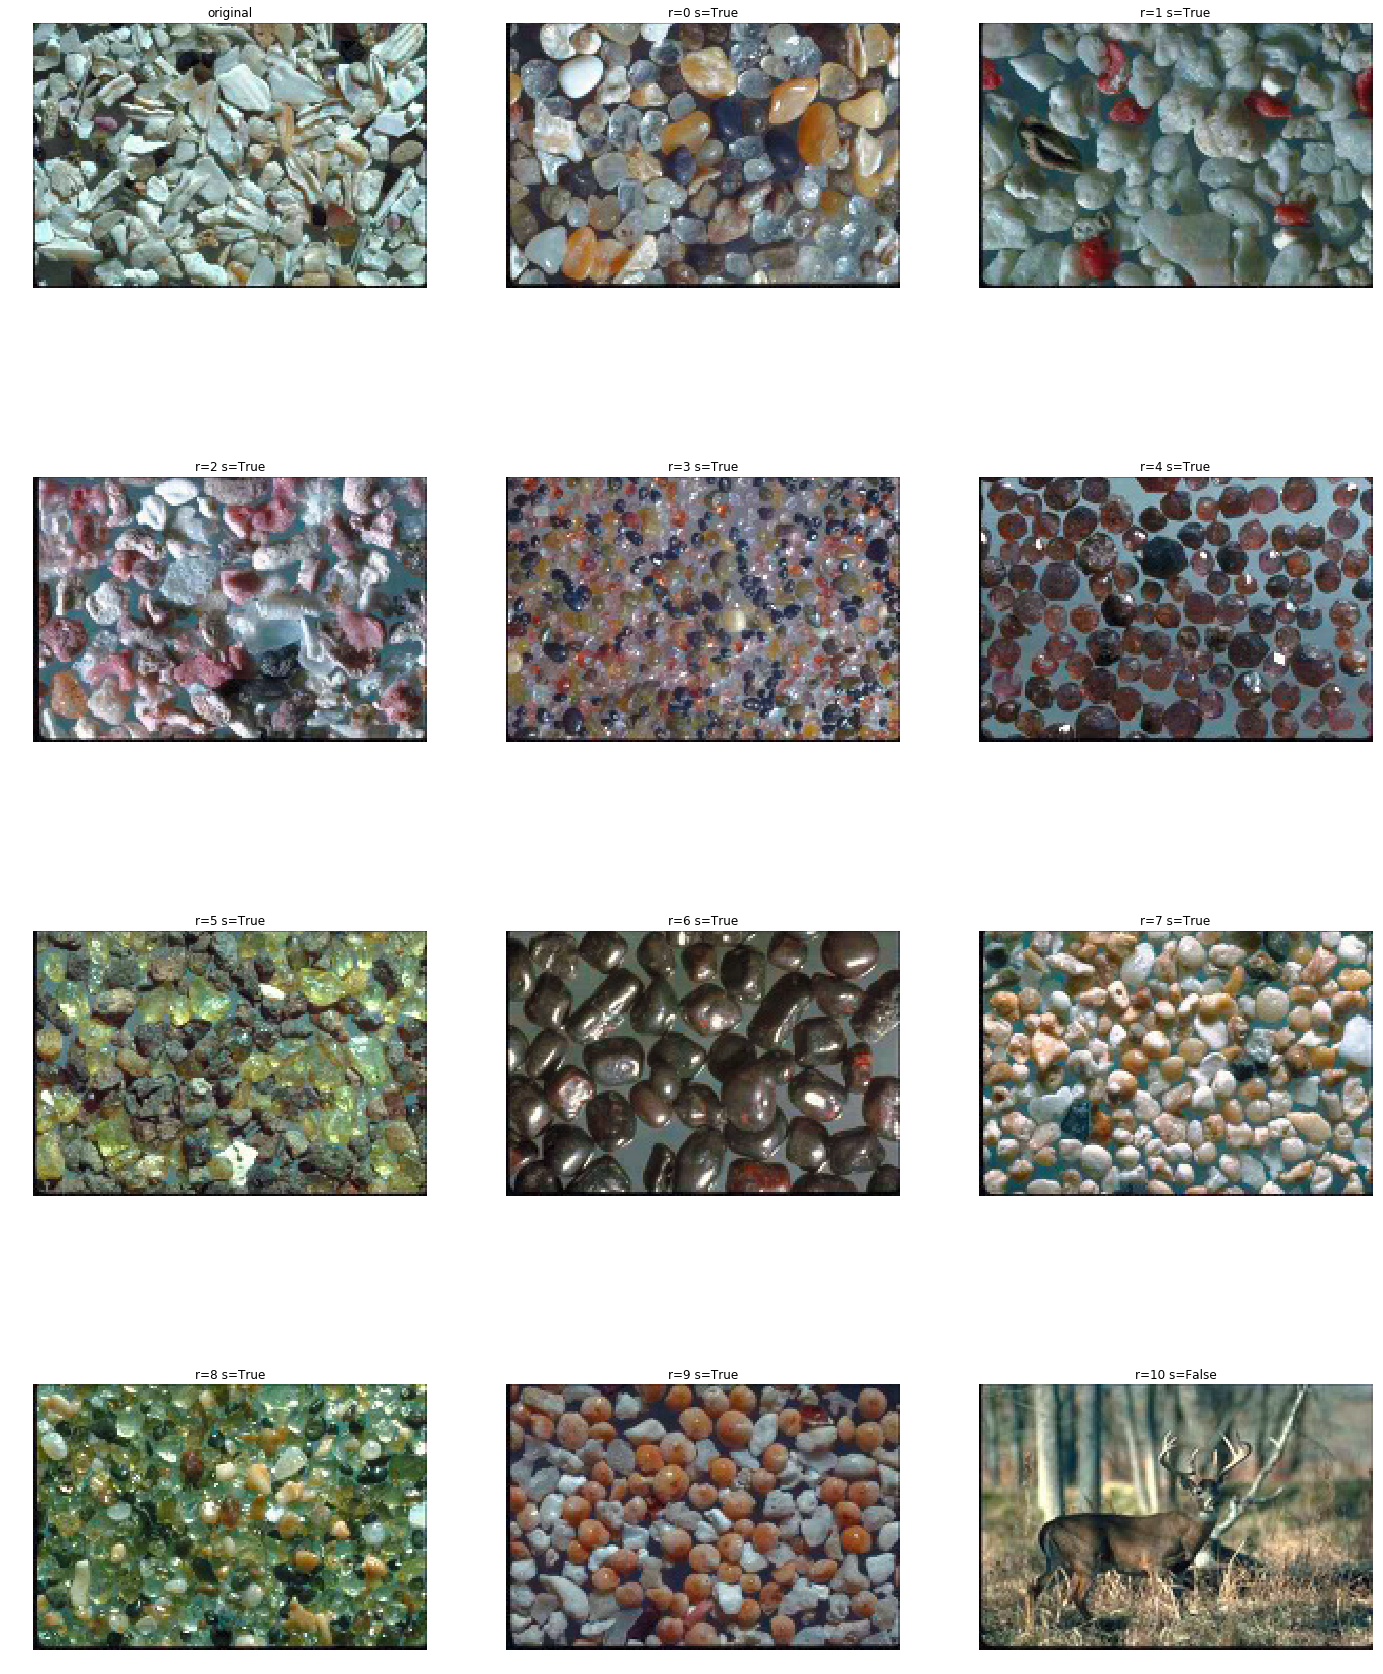

In [81]:
q_show(random.sample(X_test, 1)[0])

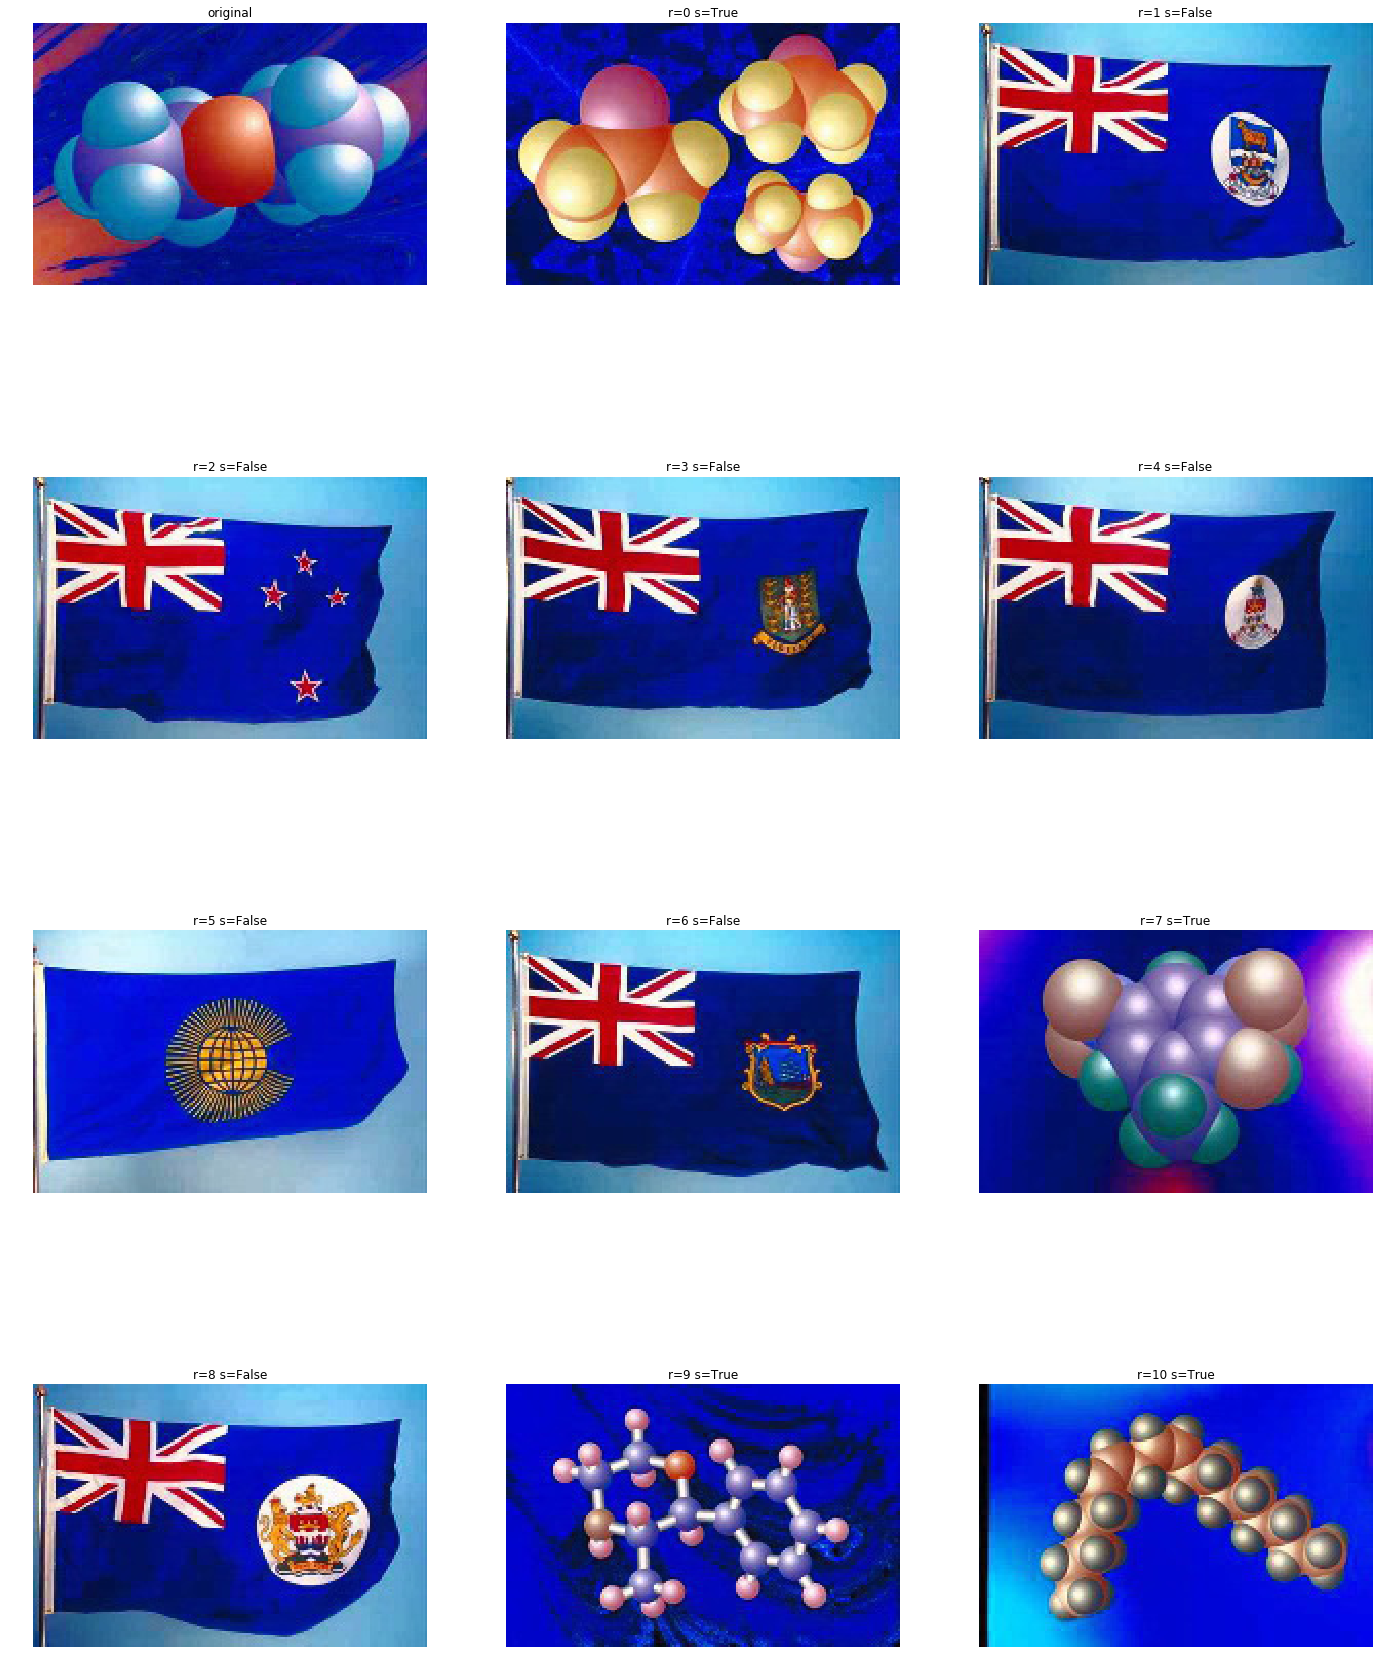

In [82]:
q_show(random.sample(X_test, 1)[0])

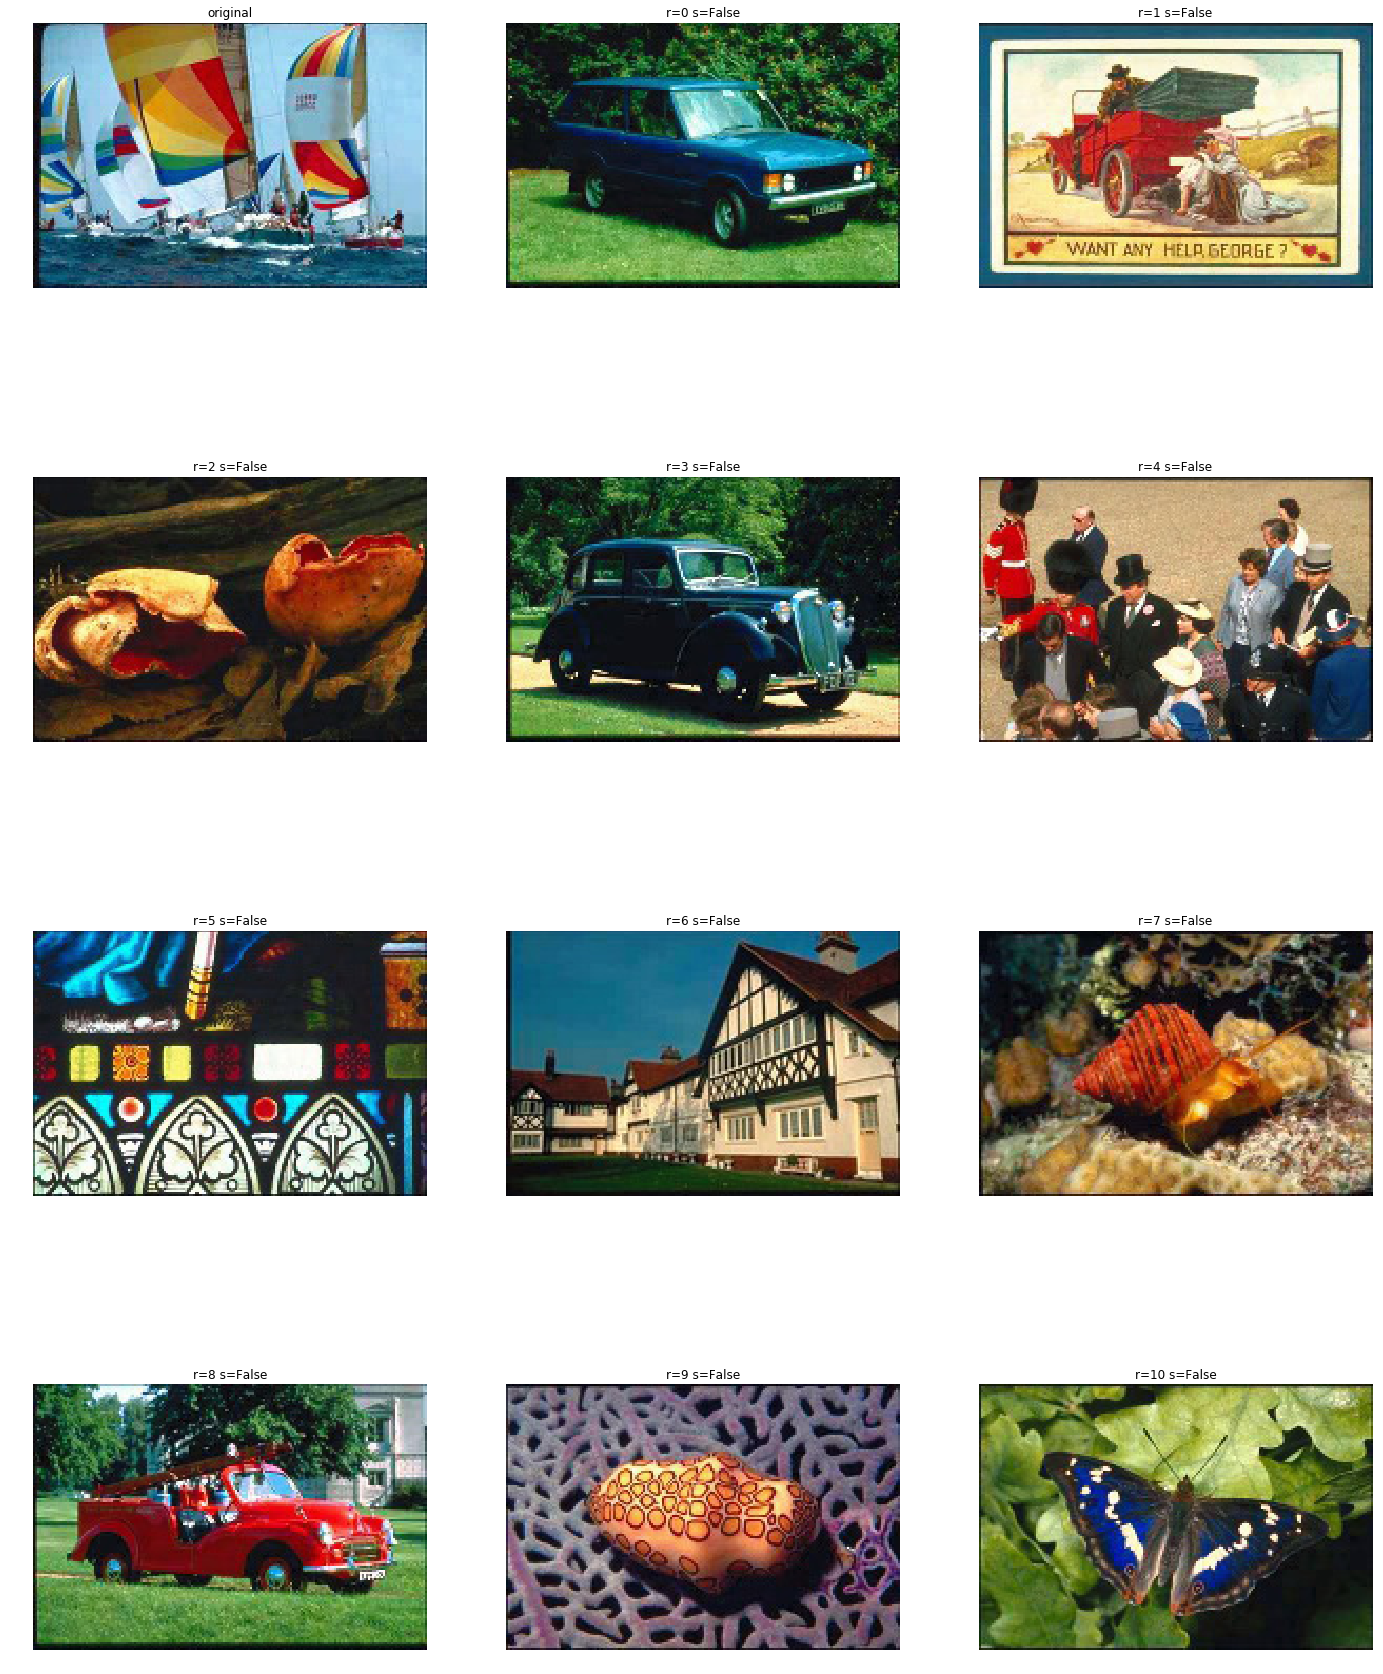

In [83]:
q_show(random.sample(X_test, 1)[0])

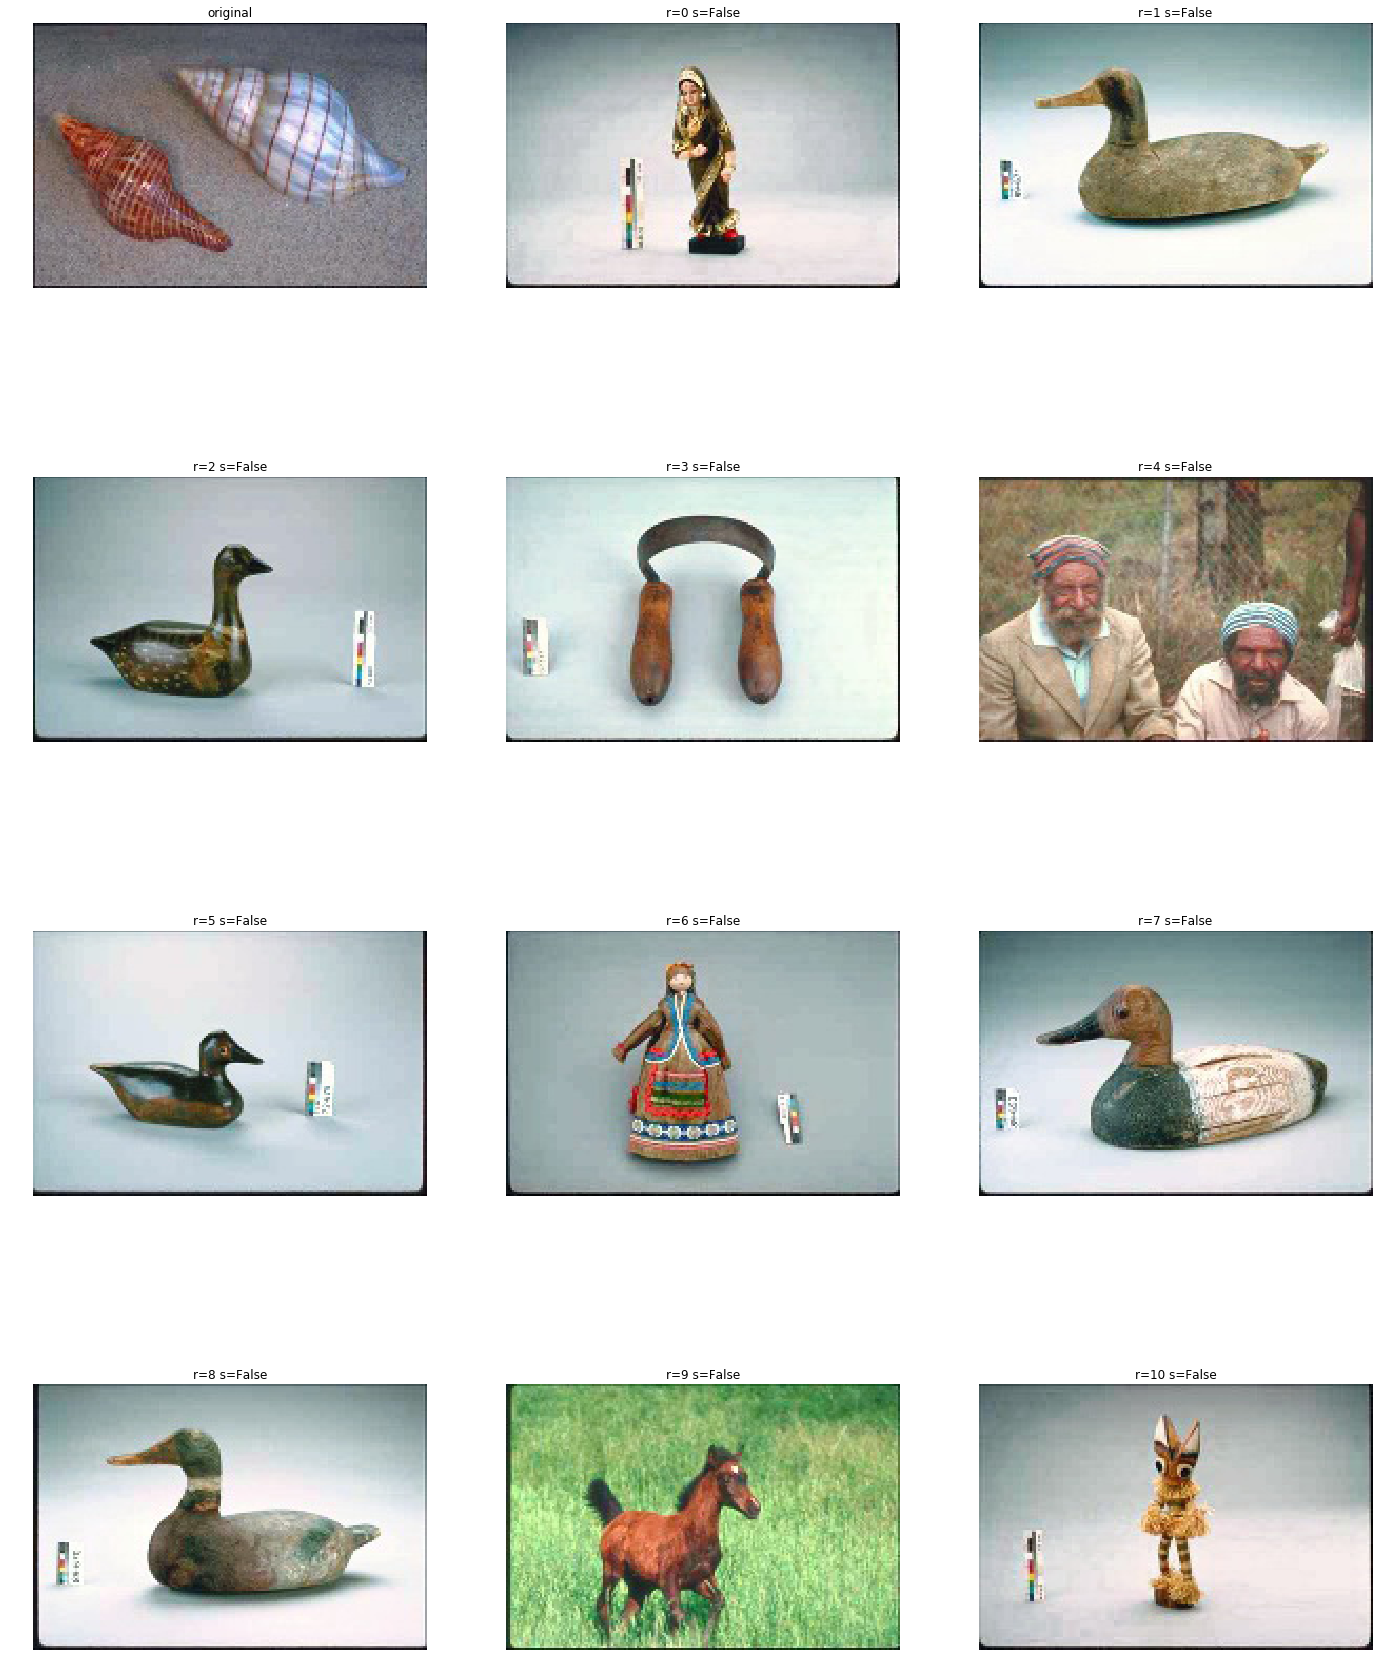

In [84]:
q_show(random.sample(X_test, 1)[0])

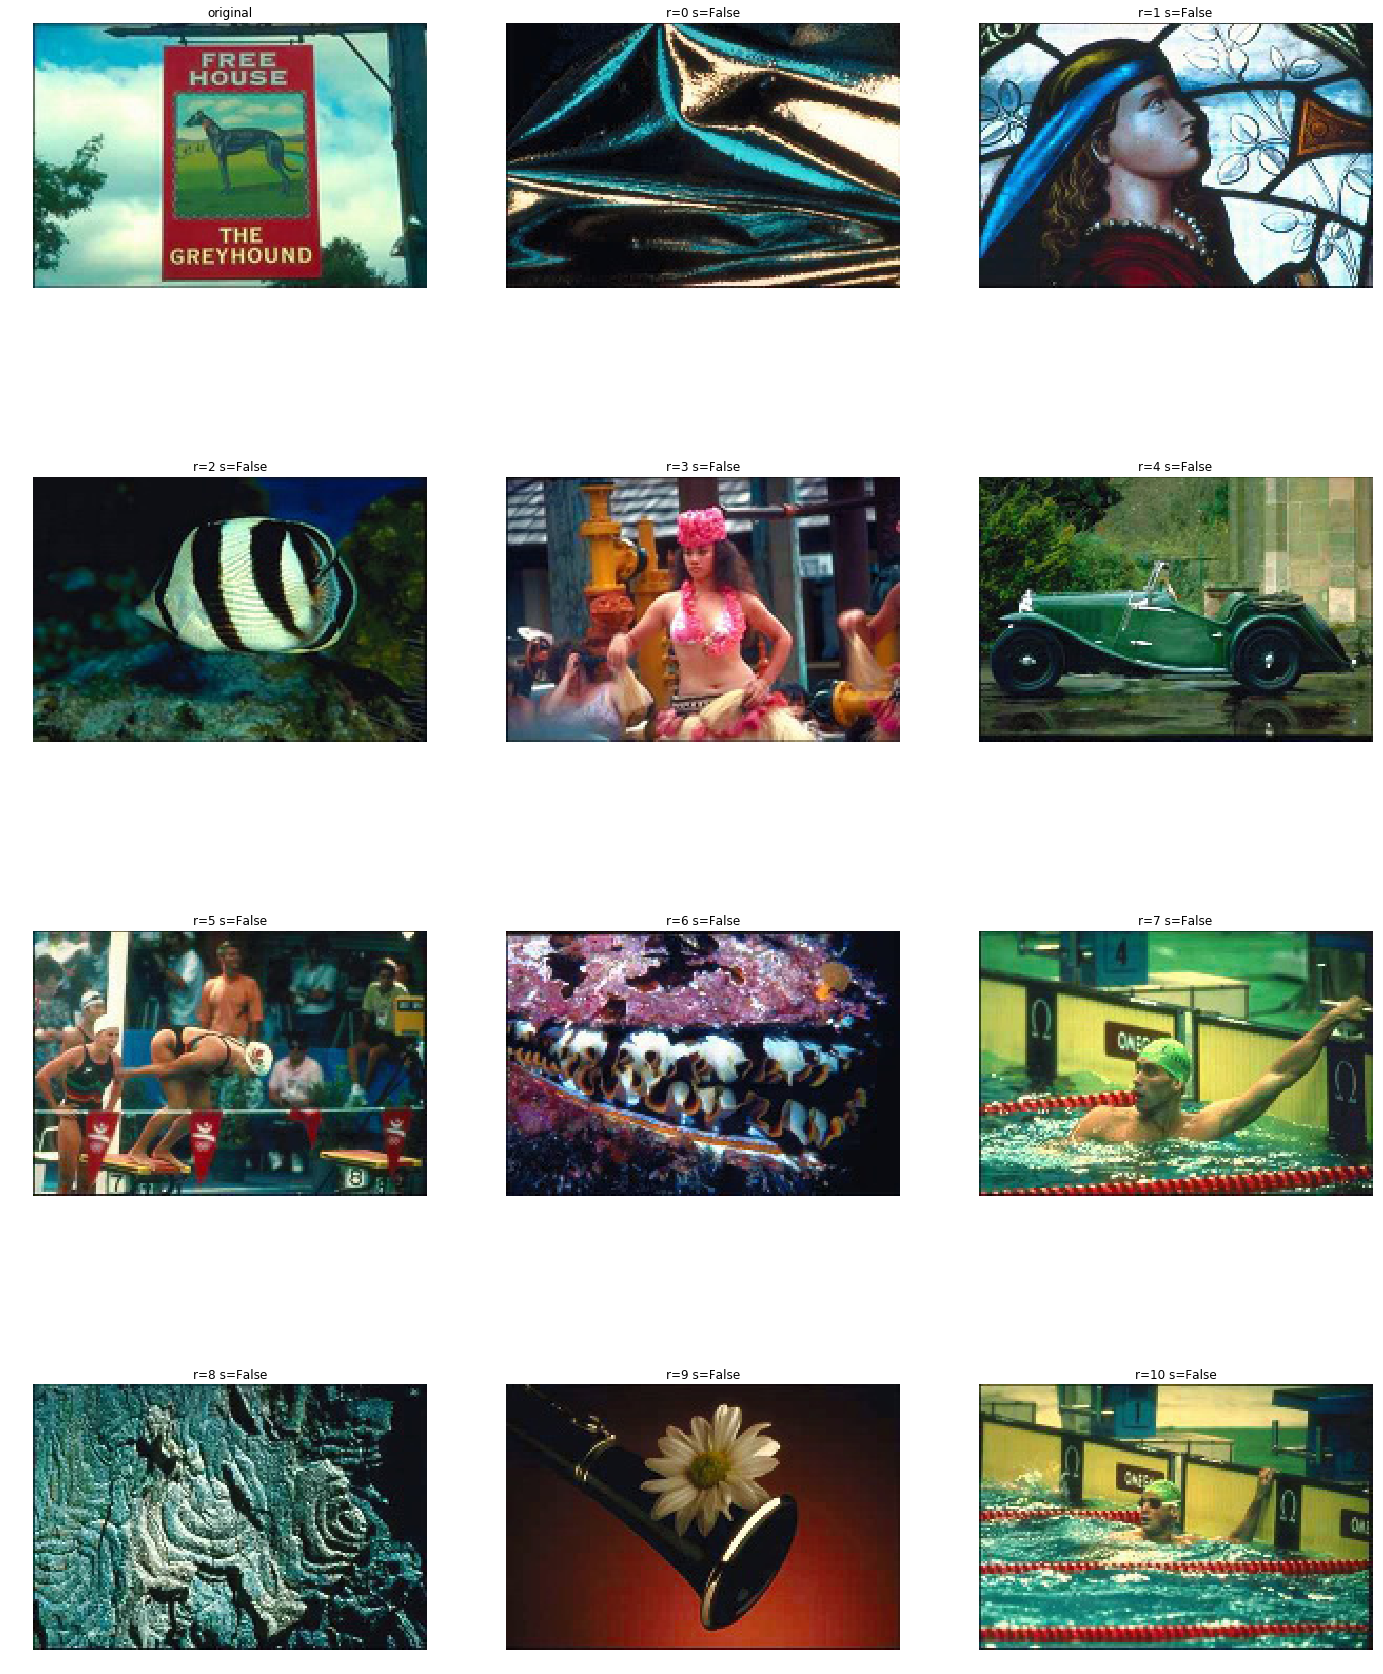

In [85]:
q_show(random.sample(X_test, 1)[0])

In [70]:
def ap_k(q, a, k=10):
    s = np.array([int(similar(q, a[i])) for i in range(k)])
    return (s / (np.arange(k) + 1)).sum() / k


def map_k(qs, ans, k=10):
    return sum(ap_k(q, a, k) for q, a in zip(tqdm.tqdm(qs), ans)) / len(qs)

In [45]:
map_k(X_test, [cbir.retrive(q) for q in tqdm.tqdm(X_test)], 10)


100%|██████████| 1000/1000 [00:00<00:00, 14221.40it/s]

0.0800564682539682